# Evaluación 1 - Entrenando redes feedforward

**Autores:**

+ Luis Saez Diaz
+ Erwin Nuñez Bracho

**Correos Electrónicos:**

+ lu.saezd@duocuc.cl
+ er.nunez@duocuc.cl

**Fecha de Creación:** 07 de Abril de 2025  
**Versión:** 0.5  

---

## Descripción

Este notebook contiene el desarrollo de la evaluación 1 de la asignatura de Deep Learning de la carrera de Ingeniería en Informática de DuocUC sede Concepción.

---

## Requisitos de Software

Este notebook fue desarrollado con Python, keras y tensorflow para el manejo de las redes neuronales y el matplotlib para la creacion de graficos con python.

# Carga de datos

In [1]:
!rm -f train-images-idx3-ubyte.gz train-labels-idx1-ubyte.gz t10k-images-idx3-ubyte.gz t10k-labels-idx1-ubyte.gz

!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz


--2025-04-20 17:52:58--  https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.179.207, 192.178.129.207, 173.194.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.179.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2025-04-20 17:52:58 (93.3 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2025-04-20 17:52:58--  https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.179.207, 192.178.129.207, 173.194.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.179.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [app

In [2]:
!ls -lh

total 12M
drwxr-xr-x 1 root root 4.0K Apr 17 13:36 sample_data
-rw-r--r-- 1 root root 1.6M Apr  6  2017 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root 4.5K Apr  6  2017 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 9.5M Apr  6  2017 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root  29K Apr  6  2017 train-labels-idx1-ubyte.gz


In [3]:
import gzip
import shutil
import struct
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

from tensorflow import keras
# Asegurar que las etiquetas están en formato correcto
from keras.utils import to_categorical
from keras.models import Sequential

# Carga de imágenes

In [4]:
# Función para cargar imágenes MNIST
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)  # Saltar los primeros 16 bytes del encabezado
    return data.reshape(-1, 28 * 28).astype("float32") / 255.0  # Aplanar y normalizar

# Función para cargar etiquetas MNIST
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)  # Saltar los primeros 8 bytes del encabezado
    return keras.utils.to_categorical(labels, 10)  # One-hot encoding para clasificación

# Cargar los datos
X_train = load_mnist_images("train-images-idx3-ubyte.gz")
y_train = load_mnist_labels("train-labels-idx1-ubyte.gz")
X_test = load_mnist_images("t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels("t10k-labels-idx1-ubyte.gz")

# Verificar dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (60000, 784), y_train: (60000, 10)
X_test: (10000, 784), y_test: (10000, 10)


La cantidad de datos en la muestra de entrenamiento es de 60.000 datos,
al vectorizarlos (aplanar) nos queda que las imagenes representan 784 pixeles vectorizados. En el caso de nuestra muestra de evaluación tenemos 10.000
con la misma cantidad de pixeles vectorizados y en el caso de las etiquetas tenemos que son 10.

Posteriormente a la carga los datos son normalizados, re-ajustando sus valores en valores de 0 a 255 lo que permite que todos mantengan un mismo rango de valores (formato) y no hayas valores que se disparen a diferencia de los demas.

# Muestra imágenes

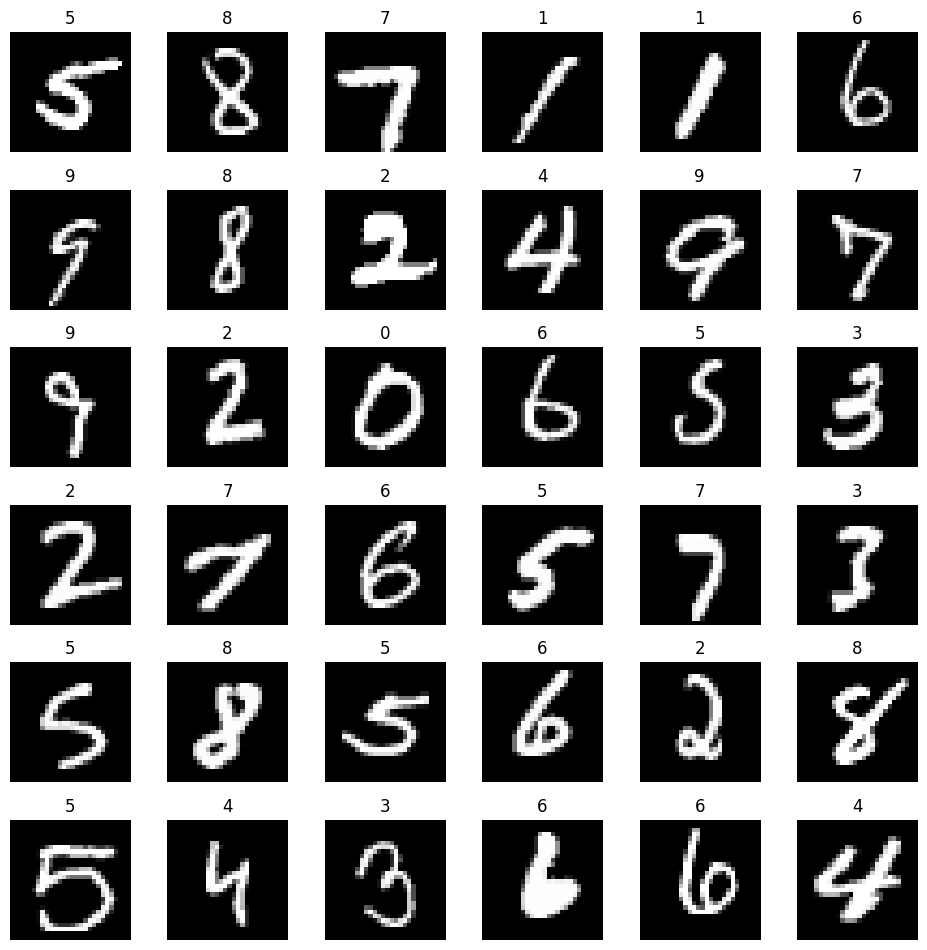

In [5]:
h, w = 6, 6  # tamaño de la grilla
fig, axs = plt.subplots(h, w, figsize=(1.6*h, 1.6*w))

for i in range(h):
    for j in range(w):
        idx = np.random.randint(len(X_train))  # índice aleatorio
        img = X_train[idx].reshape(28, 28)  # redimensionar imagen
        label = np.argmax(y_train[idx])     # obtener etiqueta

        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set_title(str(label))
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

Hacemos una muestra aleatoria de los datos y sus etiquetas de nuestro set de datos de entrenamiento donde podemos ver que es un set de datos que contiene imagenes en blanco y negro de numeros del 0 al 9.

La carga y el preprocesamiento son pasos fundamentales porque los modelos no pueden trabajar directamente con archivos como .jpg o .png, sino que necesitan tensores (matrices numéricas) como entrada. Primero, al cargar las imágenes, estas se transforman en matrices tridimensionales (por ejemplo, 224×224×3 para imágenes RGB). Luego, durante el preprocesamiento, se redimensionan a un tamaño uniforme requerido por el modelo, se normalizan los valores de píxeles (generalmente a un rango entre 0 y 1 o entre -1 y 1) para mejorar la estabilidad y eficiencia del entrenamiento, y se aplican técnicas de aumento de datos (como rotaciones, recortes o espejados) para generar variaciones artificiales que ayudan a evitar el sobreajuste. Finalmente, todo esto se convierte en tensores que pueden ser procesados por las redes neuronales. Estos pasos aseguran que las imágenes estén en el formato adecuado y optimizadas para entrenar modelos de forma eficiente y precisa.

# Red neuronal 1: Optimizador Adamax

## Red base

Para esta fase de experimentación, siendo que nuestros datos no tienen una gran dispersion ya que trabajan unicamente con 2 colores, se tomo la decision de utilizar los optimizadores de Adamax y Nadam, adamax siendo la mejora del optimizador adam que suele tener buen rendimiento en la mayoria de los casos y Nadam siendo el optimizador adam pero agregandole momentum. Esto nos permitira saber como se comporta nuestra red neuronal con un optimizador que posea momentum y nos permita optimizar los tiempos en los que ajusta los pesos.

en el caso de la funcion de perdida utilizaremos **categorical crossentropy** ya que es la que se comporta mejor con datos que esten en formato one hot enconding, en este caso nuestras clases estan formateadas de esa forma.

In [6]:
history = {} # creamos el historial para guardar los resultados de los modelos

input_shape = X_train.shape[1]
labels_output = y_train.shape[1]
print(input_shape)
print(y_train.shape[1])

# estructura de layers: [512, 256, 128, 64]
def create_model(name:str, input:int, output:int, layers:np.ndarray, optimizer:str, activation:str = 'relu', dropout:np.ndarray = np.array([0, 0])):
  model = keras.Sequential(name=name)
  model.add(keras.layers.Input(shape=(input,), name="input_layer"))

  dropout_count = 0

  for i in range(len(layers)):
    model.add(keras.layers.Dense(layers[i], activation=activation, name=f'hide_layer{i+1}'))

    if(dropout[0] > 0 and dropout_count != dropout[0]):
      model.add(keras.layers.Dropout(dropout[1]))
      dropout_count+=1
  model.add(keras.layers.Dense(output, activation="softmax", name="output_layer"))

  model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
  )

  return model


def train_model(history, model:Sequential, X_train, y_train, X_test, y_test, epochs:int = 10, batch_size:int = 10):

  result = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
  history[model.name] = { 'result': result }

  return history

784
10


Evaluamos cuantas neuronas tendra la capa de entrada (784) y la capa de salida (10) correspondiente a la cantidad de datos que entraran y la cantidad de clases con las que debera responder la red neuronal. Ademas se setean semillas randoms para tensorflow y numpy para asegurar la aleatoriedad.

In [7]:
layers = np.array([512, 256, 128, 64]) #seteamos la cantidad de capas ocultas y la cantidad de neuronas
model = create_model("adamax_base", input_shape, labels_output, layers, "adamax")

En este estudio, teniendo en cuenta el hecho de que la muestra de datos que se nos no tiene una alta dispersion (ya que es blanco y negro) y no posee desbalance de clases segun el contexto proporcionado por el docente. Se tomo la decision de utilizar en todos los experimentos una tasa de aprendizaje de 0.001, que es el valor por defecto que traen los modelos. Con esta naturaleza y contexto el valor predeterminado es el mas optimo ya que no sera tan rapido como para que las redes neuronales sean inestables ni muy lento como para que quede atrapada en un minimo local.

En este caso se tomo la decision de utilizar unicamente la precisión (accuracy) ya que es la metrica mas relevente para la problematica presentada. El f1-score solo nos sera util si hay presente desbalance de clase y este no es el caso (informacion entregada por el negocio - docente).

La precision y el recall, su interpretacion, habla sobre clase positiva y clase negativa haciendo alucion a un modelo de prediccion binario, es decir que solo tiene 2 clases. En este caso nuestro modelo es multi-clase por lo que estas metricas pierden total relevancia dado el enfoque de nuestro modelo.

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 71s 11ms/step - accuracy: 0.8814 - loss: 0.3869 - val_accuracy: 0.9650 - val_loss: 0.1138
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 73s 12ms/step - accuracy: 0.9713 - loss: 0.0946 - val_accuracy: 0.9746 - val_loss: 0.0827
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 61s 9ms/step - accuracy: 0.9819 - loss: 0.0587 - val_accuracy: 0.9780 - val_loss: 0.0734
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - accuracy: 0.9882 - loss: 0.0387 - val_accuracy: 0.9765 - val_loss: 0.0789
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 84s 9ms/step - accuracy: 0.9919 - loss: 0.0272 - val_accuracy: 0.9808 - val_loss: 0.0704
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9949 - loss: 0.0172 - val_accuracy: 0.9814 - val_loss: 0.0690
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.9959 - loss: 0.0142 - val_accuracy: 0.9834 - val_loss: 0.0670
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - accuracy: 0.9973 - loss:

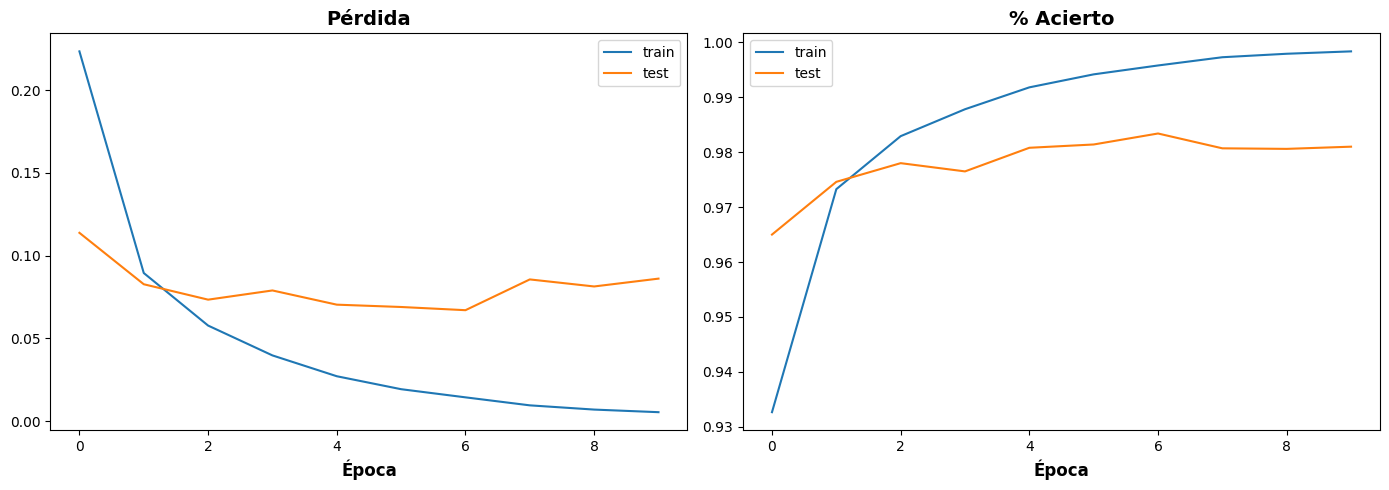

In [8]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()

Se hace el entrenamiento de la red neuronal base utilizando 10 epocas y sin aplicar agrupaciones (batch size) esto para evaluar el comportamiento del modelo con todas las entradas, sin aplicar segmentacion y realizando el entrenamiento estrictamente estocastico lo cual hara que nuestra red se ajuste utilizando una por una las muestras.

Como podemos observar en la epoca 5 el rendimiento tanto en training como en testing sigue aumentando sin haber una diferencia notable pero la perdida en la fase de testing empieza a aumentar quedando asi una diferencia algo notable en la epoca 10 en ambas perdidas.

Accuracy: 99.87% (Training) / 98.10% (testing) -> 1.77% de diferencia

Perdida: 0.0043 / 0.0861 -> 0.0818 diferencia de perdidas

Esto indica que el modelo base, al no presentar una diferencia notable entre el rendimiento durante el training y el testing se puede decir que esta generalizando de manera casi "perfecta", pese a esto se continuara con la experimentacion de distintos factores de la red neuronal para evaluar su comportamiento.

## Experimento 1: Aumento de batch Size

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.8803 - loss: 0.4227 - val_accuracy: 0.9638 - val_loss: 0.1136
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9689 - loss: 0.1026 - val_accuracy: 0.9720 - val_loss: 0.0894
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9796 - loss: 0.0656 - val_accuracy: 0.9746 - val_loss: 0.0774
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9864 - loss: 0.0438 - val_accuracy: 0.9801 - val_loss: 0.0669
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9908 - loss: 0.0298 - val_accuracy: 0.9778 - val_loss: 0.0756
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9921 - loss: 0.0237 - val_accuracy: 0.9796 - val_loss: 0.0702
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9962 - loss: 0.0144 - val_accuracy: 0.9822 - val_loss: 0.0662
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9974 -

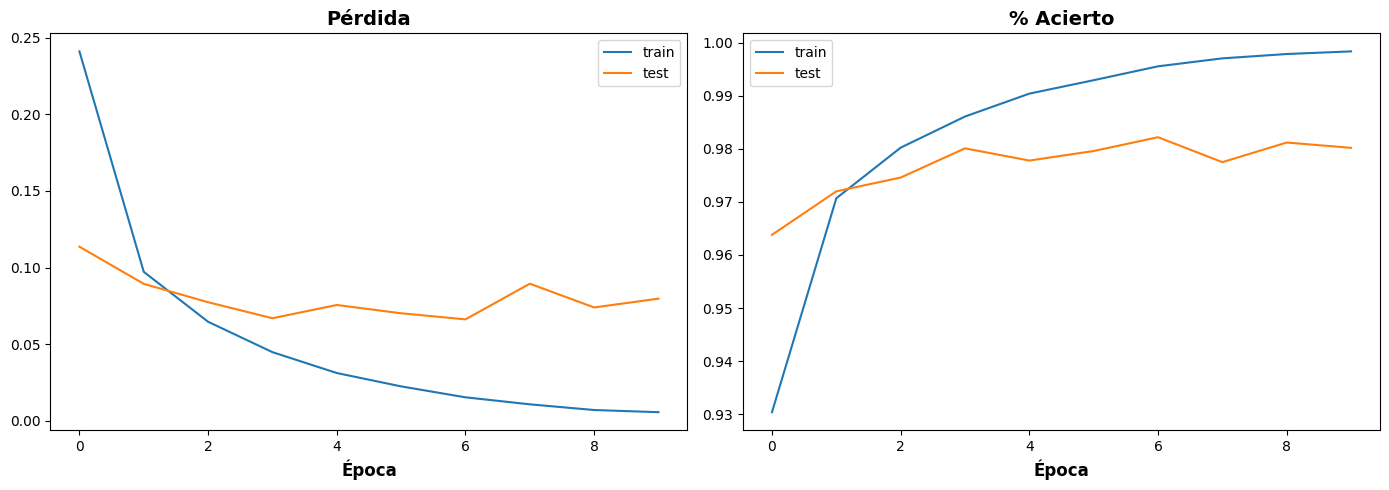

In [9]:
layers = np.array([512, 256, 128, 64]) #seteamos la cantidad de capas ocultas y la cantidad de neuronas
model = create_model("adamax_exp1", input_shape, labels_output, layers, "adamax")

history = train_model(history, model, X_train, y_train, X_test, y_test, 10, 32)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()

Se aumento el batch size a 10 para evitar que la red haga reajustes del peso con cada una de las muestras que recibe, esto permitira optimizar el tiempo de entrenamiento y poder suavizar el ruido que pueda presentar cada fase del entrenamiento por los mini ajustes que aplica.

A diferencia del entrenamiento base, en este caso ya en la epoca 3 se empieza a notar un aumento en la perdida y baja en la presicion del testing, se utilizara los resultados de la epoca 4 como evaluacion ya que es la ultima epoca en donde el modelo no empieza a perder rendimiento.

Accuracy: 99.86% (Training) / 98.02% (testing) -> 1.84% de diferencia

Perdida: 0.0049 / 0.0797 -> 0.0748 diferencia de perdidas

Como podemos ver el rendimiento del modelo, de nuestro primer experimento, se vio afectado negativamente ya que aumento ligeramente la diferencia tanto de perdida como de precision entre la fase de training y testing.

Aun asi, viendo que la diferencia no es tan alta se utilizara el batch size de 10 para los siguientes experimentos ya que al tener una muestra de datos balanceada y bien distribuida mitiga el ruido que puede generar cada muestra en el entrenamiento estocastico por lo que al aumentar el batch size se optimiza bastante el tiempo de ejecución.

## Experimento 2: Funcion de activacion Elu

In [10]:
layers = np.array([512, 256, 128, 64]) #seteamos la cantidad de capas ocultas y la cantidad de neuronas
model = create_model("adamax_exp2", input_shape, labels_output, layers, "adamax", "elu")

En este experimento se realizo una modificacion en la funcion de activacion de las capas ocultas, esto con el fin de evaluar si el rendimiento se ve afectado debido a que el calculo matematico que realiza la red en el entrenamiento (para calcular los pesos) esta dando 0 lo que indica que la neurona queda "muerta".

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 58s 9ms/step - accuracy: 0.9005 - loss: 0.3270 - val_accuracy: 0.9619 - val_loss: 0.1292
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9663 - loss: 0.1086 - val_accuracy: 0.9705 - val_loss: 0.0916
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.9777 - loss: 0.0690 - val_accuracy: 0.9753 - val_loss: 0.0762
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - accuracy: 0.9843 - loss: 0.0505 - val_accuracy: 0.9771 - val_loss: 0.0746
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 84s 9ms/step - accuracy: 0.9866 - loss: 0.0397 - val_accuracy: 0.9779 - val_loss: 0.0694
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - accuracy: 0.9910 - loss: 0.0285 - val_accuracy: 0.9802 - val_loss: 0.0679
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 85s 9ms/step - accuracy: 0.9923 - loss: 0.0234 - val_accuracy: 0.9792 - val_loss: 0.0702
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - accuracy: 0.9938 - loss: 0

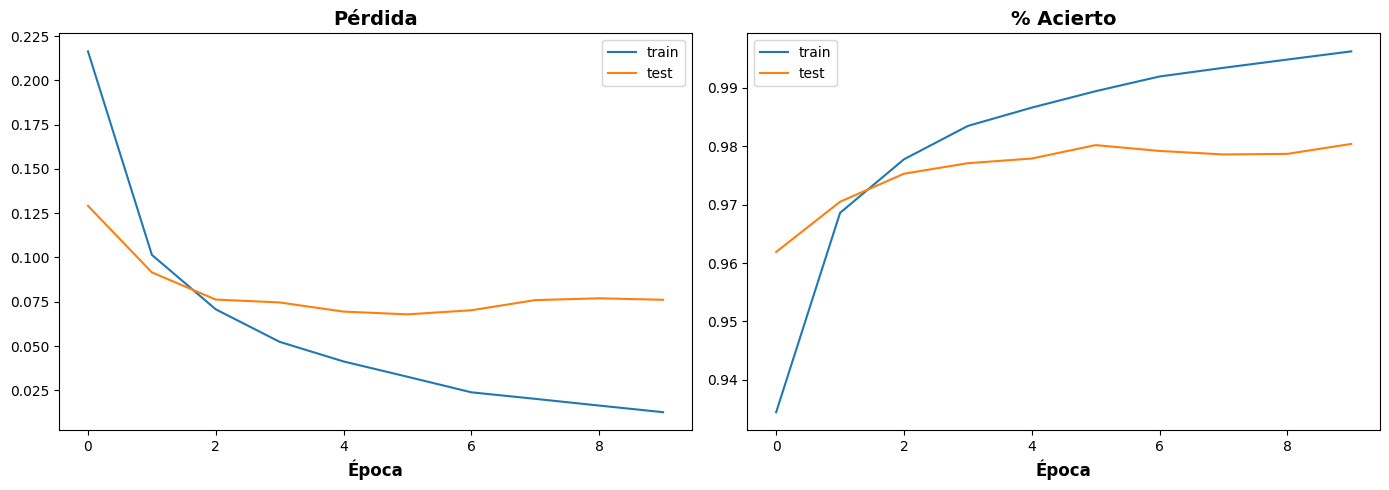

In [11]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()

Luego de aplicar el cambio en la funcion de activacion se puede observar fluctuaciones de perdida disparejas en cada epoca, en vez de ir aumentando o disminuyendo en cada epoca, va fluctuando hacia arriba y hacia abajo en cada una.

Accuracy: 99.55% (Training) / 97.95% (testing) -> 2% de diferencia

Perdida: 0.0106 / 0.0761 -> 0.0659 diferencia de perdidas

Tomando los resultados de la ultima epoca podemos observar que al aplicar el cambio en la funcion de activacion aumenta ligeramente la diferencia de precision entre la fase de training y testing, siendo esta de un 2% pero se disminuye considerablemente la diferencia de perdida entre ambas fases (Siendo mas relevante la disminucion de la perdida en la fase de testing).

## Experimento 3: Anexo de una capa oculta extra

In [12]:
layers = np.array([512, 256, 128, 64, 32]) # agregamos una capa oculta de 32 neuronas
model = create_model("adamax_exp3", input_shape, labels_output, layers, "adamax", "elu")

En este experimento se anexo de una capa oculta lo que puede permitir el refinamiento del aprendizaje de la red neuronal ya que le permitira aprender patrones mas complejos al aplicar otra fase de procesamiento de datos.

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 57s 9ms/step - accuracy: 0.8936 - loss: 0.3512 - val_accuracy: 0.9609 - val_loss: 0.1313
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.9644 - loss: 0.1152 - val_accuracy: 0.9673 - val_loss: 0.1022
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - accuracy: 0.9770 - loss: 0.0720 - val_accuracy: 0.9719 - val_loss: 0.0906
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - accuracy: 0.9831 - loss: 0.0558 - val_accuracy: 0.9733 - val_loss: 0.0810
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9867 - loss: 0.0400 - val_accuracy: 0.9779 - val_loss: 0.0738
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - accuracy: 0.9897 - loss: 0.0325 - val_accuracy: 0.9751 - val_loss: 0.0808
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - accuracy: 0.9927 - loss: 0.0239 - val_accuracy: 0.9804 - val_loss: 0.0649
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.9935 - loss: 0

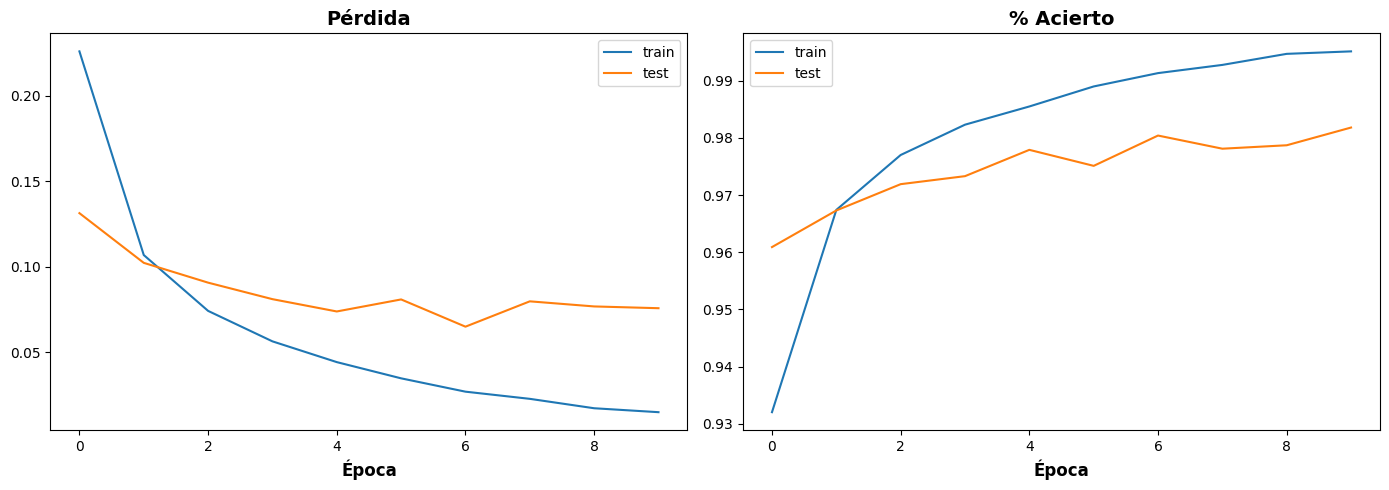

In [13]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()

Como se puede observar el rendimiento en la fase de testing, junto a su perdida, se vio afectado negativamente a partir de la epoca numero 8 por lo que se tomo la decision de realizar la evalucion de la red neuronal tomando las metricas de esa epoca.

Accuracy: 99.60% (Training) / 98.18% (testing) -> 1.42% de diferencia

Perdida: 0.0127 / 0.0757 -> 0.0630 diferencia de perdidas

como podemos observar, al agregar una capa oculta a nuestra red neuronal y volviendo a utilizar la funcion de activacion **relu** se puede ver una mejoria en el rendimiento del modelo ya que no se sacrifica tanta precision como en experimentos anteriores pero se ve una diferencia y disminucion notable en la perdida de ambas fases (training & testing) esto puede deberse a que la red neuronal, con una capa oculta extra, esta identificando patrones mas complejos en nuestros datos lo que permite que entregue una respuesta mas acertada.

## Experimento 4: Aumento de neuronas

In [14]:
layers = np.array([1024, 512, 256, 128]) # duplicamos las neuronas de las capas ocultas
model = create_model("adamax_exp4", input_shape, labels_output, layers, "adamax")

En este experimento se tomo la decision de duplicar las neuronas de cada una de las 4 capas ocultas, esto con el fin de poder entregar mas memoria a la red neuronal y permitira una mayor capacidad de analisis de cada uno de los datos que vienen en nuestra muestra.

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 111s 18ms/step - accuracy: 0.9020 - loss: 0.3198 - val_accuracy: 0.9729 - val_loss: 0.0915
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 110s 18ms/step - accuracy: 0.9756 - loss: 0.0757 - val_accuracy: 0.9732 - val_loss: 0.0834
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 143s 18ms/step - accuracy: 0.9864 - loss: 0.0442 - val_accuracy: 0.9802 - val_loss: 0.0607
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 141s 18ms/step - accuracy: 0.9913 - loss: 0.0273 - val_accuracy: 0.9765 - val_loss: 0.0799
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 140s 18ms/step - accuracy: 0.9948 - loss: 0.0169 - val_accuracy: 0.9803 - val_loss: 0.0715
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 141s 18ms/step - accuracy: 0.9972 - loss: 0.0094 - val_accuracy: 0.9802 - val_loss: 0.0769
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 144s 18ms/step - accuracy: 0.9980 - loss: 0.0068 - val_accuracy: 0.9826 - val_loss: 0.0733
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 110s 18ms/step - accuracy: 

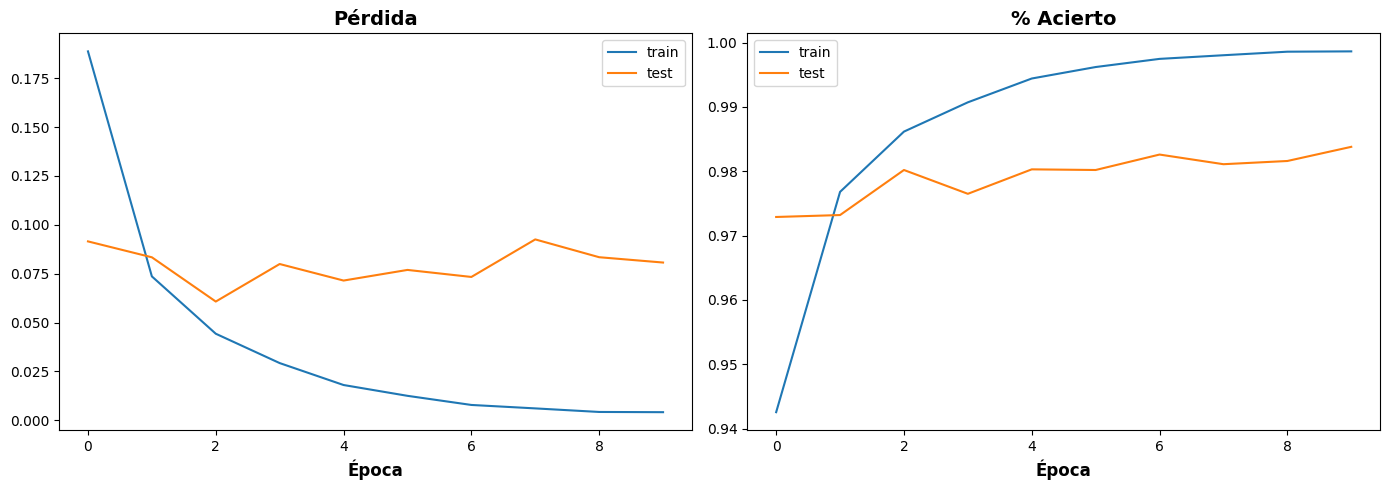

In [15]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()

En este caso notamos que el rendimiento, como ocurrio en el experimento donde se aumentaron las capas ocultas, tiene fluctuaciones.

Accuracy: 99.90% (Training) / 98.38% (testing) -> 1.52% de diferencia

Perdida: 0.0033 / 0.0807 -> 0.0774 diferencia de perdidas

En este caso aumento la diferencia entre la precision de training & testing junto a la diferencia de perdida de ambas fases. Esto puede deberse al hecho de que la muestra que se esta utilizando no posee tanta variabilidad ni mucha complejidad en sus datos y el aumentar las neuronas solo ocasiono que aumente el rudio lo que puede influir negativamente en el rendimiento del modelo.

## Experimento 5: Apagado de neuronas

In [16]:
layers = np.array([512, 256, 128, 64]) #seteamos la cantidad de capas ocultas y la cantidad de neuronas

model = create_model("adamax_exp5", input_shape, labels_output, layers, "adamax", dropout=np.array([2, 0.2]))

En este ultimo experimento se tomo la decision de aplicar un apagado del 20% de neuronas en la capa oculta 1 y 2 para ver como se comporta el modelo.

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - accuracy: 0.8582 - loss: 0.4641 - val_accuracy: 0.9641 - val_loss: 0.1148
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - accuracy: 0.9604 - loss: 0.1315 - val_accuracy: 0.9745 - val_loss: 0.0872
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.9719 - loss: 0.0878 - val_accuracy: 0.9753 - val_loss: 0.0796
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 85s 9ms/step - accuracy: 0.9793 - loss: 0.0671 - val_accuracy: 0.9825 - val_loss: 0.0627
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - accuracy: 0.9833 - loss: 0.0552 - val_accuracy: 0.9805 - val_loss: 0.0644
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - accuracy: 0.9849 - loss: 0.0470 - val_accuracy: 0.9788 - val_loss: 0.0714
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.9873 - loss: 0.0397 - val_accuracy: 0.9823 - val_loss: 0.0656
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - accuracy: 0.9899 - loss: 0

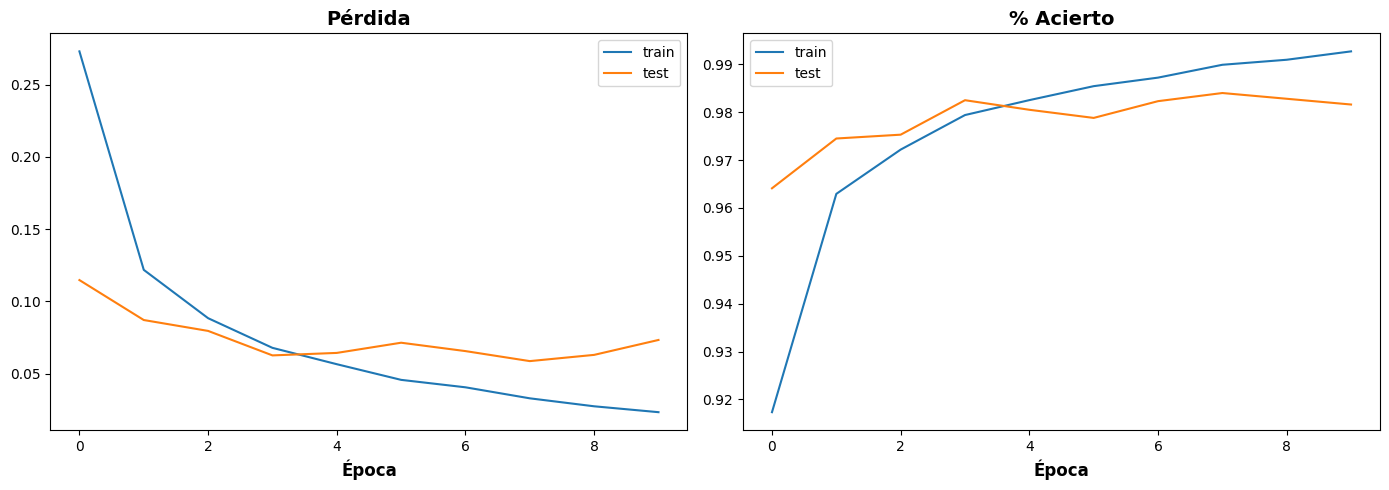

In [17]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()

model.save(f"{model.name}.h5")

En este caso tambien se puede observar fluctuaciones en el rendimiento de ambas fases, donde a partir de la epoca 4 en rendimiento empieza a decaer por ende utilizaremos esta epoca para la evaluacion.

Accuracy: 99.28% (Training) / 98.16% (testing) -> 1.12% de diferencia

Perdida: 0.0236 / 0.0734 -> 0.0498 diferencia de perdidas

como se puede observar el rendimiento general del modelo se vio afectado negativamente, esto puede ser debido a que al aplicarse a capas tempranas se elimina informacion importante que estas pueden entregar a las capas sub-siguientes ademas el la tecnica de dropout es ideal para eviar el sobreajuste, lo cual no se observa en esta muestra de datos ya que no hay una diferencia notoria en la fase de training y testing.

# Red neuronal 2: Optimizador Nadam

## Red base

In [18]:
layers = np.array([512, 256, 128, 64]) #seteamos la cantidad de capas ocultas y la cantidad de neuronas
model = create_model("nadam_base", input_shape, labels_output, layers, "nadam")

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 67s 11ms/step - accuracy: 0.8974 - loss: 0.3365 - val_accuracy: 0.9642 - val_loss: 0.1208
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 64s 11ms/step - accuracy: 0.9682 - loss: 0.1106 - val_accuracy: 0.9673 - val_loss: 0.1201
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 80s 10ms/step - accuracy: 0.9769 - loss: 0.0800 - val_accuracy: 0.9725 - val_loss: 0.0982
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - accuracy: 0.9823 - loss: 0.0619 - val_accuracy: 0.9743 - val_loss: 0.0945
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - accuracy: 0.9861 - loss: 0.0515 - val_accuracy: 0.9757 - val_loss: 0.0989
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 83s 10ms/step - accuracy: 0.9861 - loss: 0.0466 - val_accuracy: 0.9786 - val_loss: 0.0942
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 66s 11ms/step - accuracy: 0.9894 - loss: 0.0426 - val_accuracy: 0.9776 - val_loss: 0.0926
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 80s 11ms/step - accuracy: 0.9906 -

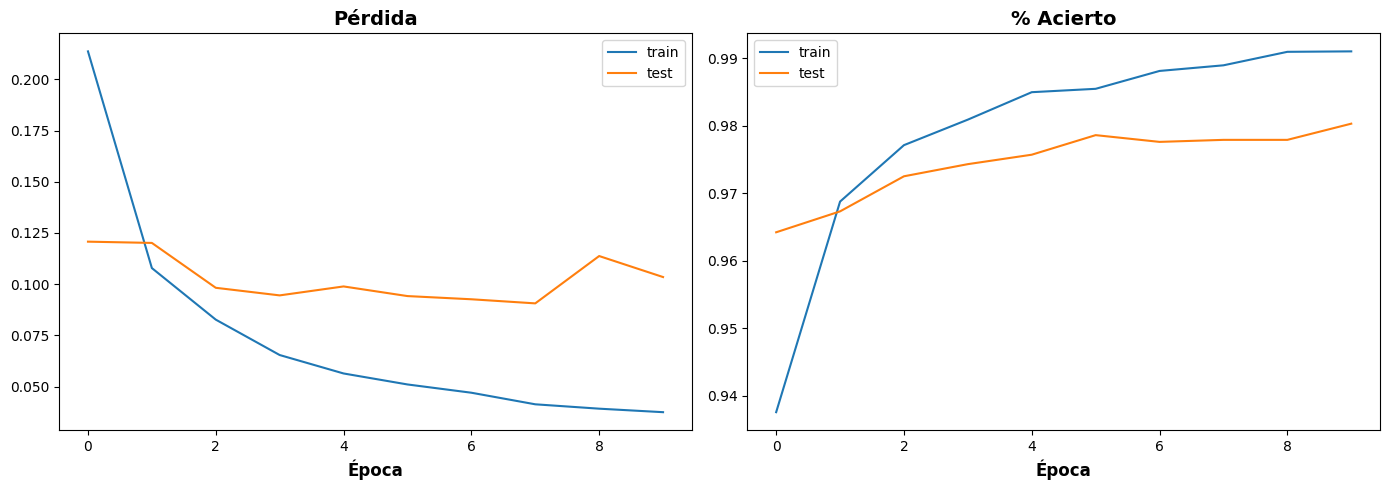

In [19]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()

Se hace el entrenamiento de la red neuronal base utilizando 10 epocas y sin aplicar agrupaciones (batch size) esto para evaluar el comportamiento del modelo con todas las entradas, sin aplicar segmentacion y realizando el entrenamiento estrictamente estocastico lo cual hara que nuestra red se ajuste utilizando una por una las muestras.

Como podemos observar en la epoca 5 el rendimiento tanto en training como en testing sigue aumentando sin haber una diferencia notable pero la perdida en la fase de testing empieza a aumentar quedando asi una diferencia algo notable en la epoca 10 en ambas perdidas.

Accuracy: 99.12% (Training) / 98.03% (testing) -> 1.09% de diferencia

Perdida: 0.0347 / 0.1035 -> 0.0688 diferencia de perdidas

Esto indica que el modelo base, al no presentar una diferencia notable entre el rendimiento durante el training y el testing se puede decir que esta generalizando de manera casi "perfecta", pese a esto se continuara con la experimentacion de distintos factores de la red neuronal para evaluar su comportamiento.

##Experimento 1: Aumento de batch Size

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.8959 - loss: 0.3434 - val_accuracy: 0.9646 - val_loss: 0.1153
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9722 - loss: 0.0892 - val_accuracy: 0.9692 - val_loss: 0.1012
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9808 - loss: 0.0619 - val_accuracy: 0.9756 - val_loss: 0.0806
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9854 - loss: 0.0469 - val_accuracy: 0.9738 - val_loss: 0.1039
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9868 - loss: 0.0419 - val_accuracy: 0.9781 - val_loss: 0.0785
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.9910 - loss: 0.0299 - val_accuracy: 0.9750 - val_loss: 0.0926
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.9913 - loss: 0.0295 - val_accuracy: 0.9808 - val_loss: 0.0793
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.9920 -

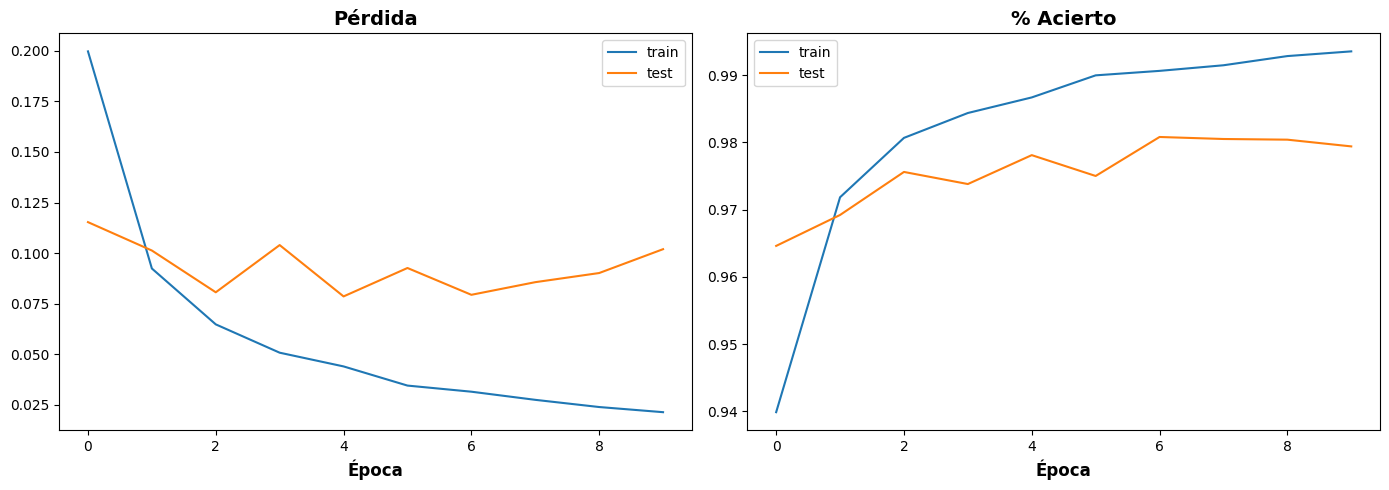

In [20]:
layers = np.array([512, 256, 128, 64]) #seteamos la cantidad de capas ocultas y la cantidad de neuronas
model = create_model("nadam_exp1", input_shape, labels_output, layers, "nadam")

history = train_model(history, model, X_train, y_train, X_test, y_test, 10, 32)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()


Se aumento el batch size a 10 para evitar que la red haga reajustes del peso con cada una de las muestras que recibe, esto permitira optimizar el tiempo de entrenamiento y poder suavizar el ruido que pueda presentar cada fase del entrenamiento por los mini ajustes que aplica.

A diferencia del entrenamiento base, en este caso podemos apreciar que la pérdida disminuye de forma constante y progresiva, lo que indica un mejor rendimiento al aumentar el batch size.

Accuracy: 99.40% (Training) / 97.94% (testing) -> 1.46% de diferencia

Perdida: 0.0198 / 0.1019 -> 0.0821 diferencia de perdidas

Gracias a los datos observados, se aprecia una mejora en el rendimiento general tanto en testing como en training, por lo que se continuará con un batch size de 10.

##Experimento 2: Funcion de activacion Elu

In [21]:
layers = np.array([512, 256, 128, 64]) #seteamos la cantidad de capas ocultas y la cantidad de neuronas
model = create_model("nadam_exp2", input_shape, labels_output, layers, "nadam", "elu")

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 63s 10ms/step - accuracy: 0.8895 - loss: 0.3608 - val_accuracy: 0.9474 - val_loss: 0.1678
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 61s 10ms/step - accuracy: 0.9571 - loss: 0.1437 - val_accuracy: 0.9635 - val_loss: 0.1314
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 84s 11ms/step - accuracy: 0.9694 - loss: 0.1049 - val_accuracy: 0.9655 - val_loss: 0.1322
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 79s 10ms/step - accuracy: 0.9756 - loss: 0.0861 - val_accuracy: 0.9745 - val_loss: 0.0940
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - accuracy: 0.9810 - loss: 0.0698 - val_accuracy: 0.9732 - val_loss: 0.1043
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - accuracy: 0.9830 - loss: 0.0605 - val_accuracy: 0.9759 - val_loss: 0.0884
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - accuracy: 0.9852 - loss: 0.0536 - val_accuracy: 0.9778 - val_loss: 0.1074
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 84s 10ms/step - accuracy: 0.9880 -

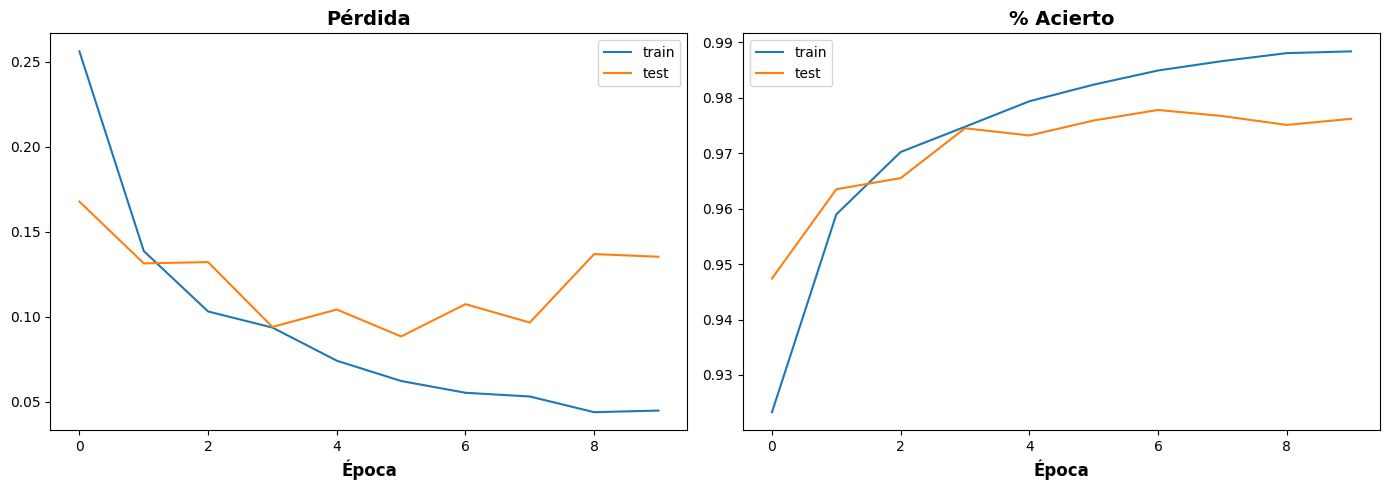

In [22]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()



Luego de aplicar el cambio en la funcion de activacion se puede observar fluctuaciones de perdida disparejas en cada epoca, en vez de ir aumentando o disminuyendo en cada epoca, va fluctuando hacia arriba y hacia abajo en cada una.

Accuracy: 98.90% (Training) / 97.62% (testing) -> 1.28% de diferencia

Perdida: 0.0416 / 0.1353 -> 0.0937 diferencia de perdidas

##Experimento 3: Anexo de una capa oculta extra

In [23]:
layers = np.array([512, 256, 128, 64, 32]) # agregamos una capa oculta de 32 neuronas
model = create_model("nadam_exp3", input_shape, labels_output, layers, "nadam", "elu")

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 66s 10ms/step - accuracy: 0.8830 - loss: 0.3915 - val_accuracy: 0.9462 - val_loss: 0.1882
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - accuracy: 0.9565 - loss: 0.1494 - val_accuracy: 0.9660 - val_loss: 0.1179
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 80s 10ms/step - accuracy: 0.9695 - loss: 0.1072 - val_accuracy: 0.9699 - val_loss: 0.1117
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - accuracy: 0.9754 - loss: 0.0859 - val_accuracy: 0.9738 - val_loss: 0.1011
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - accuracy: 0.9805 - loss: 0.0706 - val_accuracy: 0.9766 - val_loss: 0.0992
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step - accuracy: 0.9832 - loss: 0.0625 - val_accuracy: 0.9770 - val_loss: 0.0920
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - accuracy: 0.9861 - loss: 0.0515 - val_accuracy: 0.9745 - val_loss: 0.1041
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - accuracy: 0.9870 -

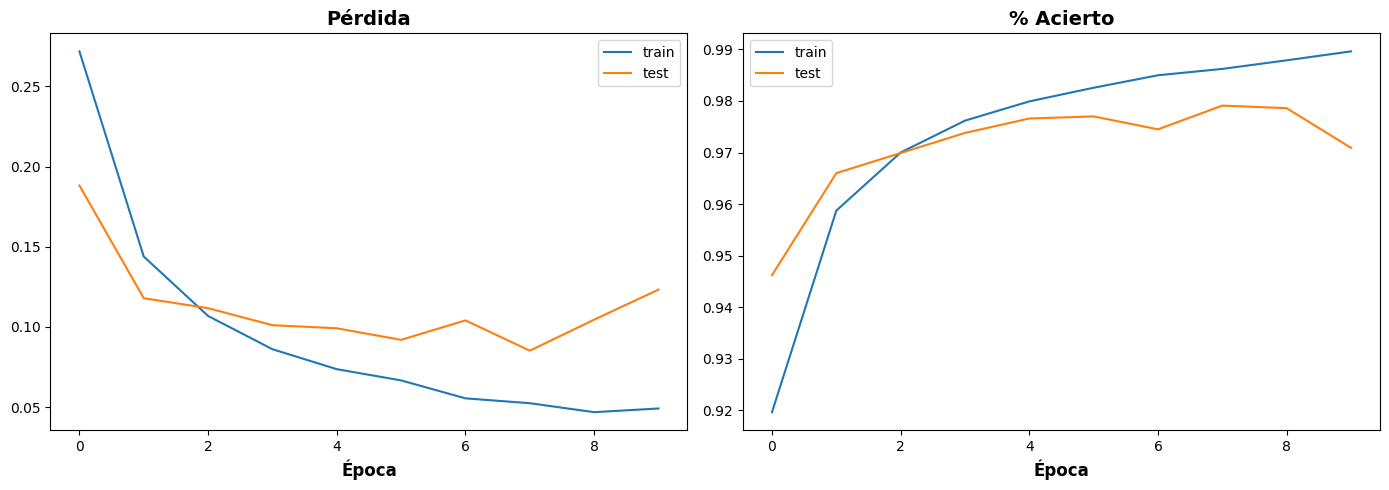

In [24]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()


Como se puede observar el rendimiento en la fase de testing, junto a su perdida, se vio afectado negativamente a partir de la epoca numero 8 por lo que se tomo la decision de realizar la evalucion de la red neuronal tomando las metricas de esa epoca.

Accuracy: 98.94% (Training) / 97.09% (testing) -> 1.85% de diferencia

Perdida: 0.0480 / 0.1233 -> 0.0753 diferencia de perdidas

como podemos observar, al agregar una capa oculta a nuestra red neuronal y volviendo a utilizar la funcion de activacion relu se puede ver una mejoria en el rendimiento del modelo ya que no se sacrifica tanta precision como en experimentos anteriores pero se ve una diferencia y disminucion notable en la perdida de ambas fases (training & testing) esto puede deberse a que la red neuronal, con una capa oculta extra, esta identificando patrones mas complejos en nuestros datos lo que permite que entregue una respuesta mas acertada.

##Experimento 4: Aumento de neuronas

In [25]:
layers = np.array([1024, 512, 256, 128]) # duplicamos las neuronas de las capas ocultas
model = create_model("nadam_exp4", input_shape, labels_output, layers, "nadam")

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 139s 23ms/step - accuracy: 0.8974 - loss: 0.3401 - val_accuracy: 0.9583 - val_loss: 0.1459
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 140s 22ms/step - accuracy: 0.9663 - loss: 0.1194 - val_accuracy: 0.9685 - val_loss: 0.1138
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 142s 22ms/step - accuracy: 0.9770 - loss: 0.0858 - val_accuracy: 0.9770 - val_loss: 0.0861
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 134s 22ms/step - accuracy: 0.9805 - loss: 0.0699 - val_accuracy: 0.9766 - val_loss: 0.1157
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 139s 22ms/step - accuracy: 0.9822 - loss: 0.0663 - val_accuracy: 0.9752 - val_loss: 0.1259
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 144s 22ms/step - accuracy: 0.9860 - loss: 0.0526 - val_accuracy: 0.9735 - val_loss: 0.1445
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 142s 22ms/step - accuracy: 0.9867 - loss: 0.0515 - val_accuracy: 0.9775 - val_loss: 0.1374
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 142s 22ms/step - accuracy: 

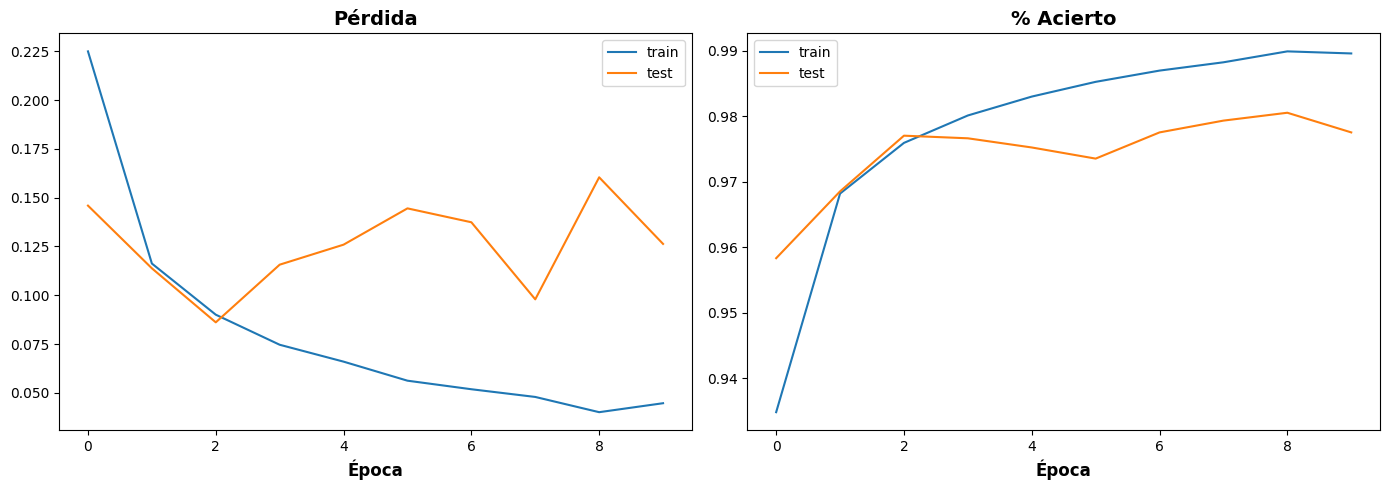

In [26]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()


En este caso notamos que el rendimiento, como ocurrio en el experimento donde se aumentaron las capas ocultas, tiene fluctuaciones.

Accuracy: 98.95% (Training) / 97.75% (testing) -> 1.20% de diferencia

Perdida: 0.0452 / 0.1263 -> 0.0811 diferencia de perdidas

En este caso aumento la diferencia entre la precision de training & testing junto a la diferencia de perdida de ambas fases. Esto puede deberse al hecho de que la muestra que se esta utilizando no posee tanta variabilidad ni mucha complejidad en sus datos y el aumentar las neuronas solo ocasiono que aumente el rudio lo que puede influir negativamente en el rendimiento del modelo.

##Experimento 5: Apagado de neuronas

In [27]:
layers = np.array([512, 256, 128, 64]) #seteamos la cantidad de capas ocultas y la cantidad de neuronas

model = create_model("nadam_exp5", input_shape, labels_output, layers, "nadam", dropout=np.array([2, 0.2]))

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 66s 10ms/step - accuracy: 0.8774 - loss: 0.3909 - val_accuracy: 0.9542 - val_loss: 0.1561
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step - accuracy: 0.9586 - loss: 0.1452 - val_accuracy: 0.9706 - val_loss: 0.1092
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 63s 10ms/step - accuracy: 0.9677 - loss: 0.1134 - val_accuracy: 0.9730 - val_loss: 0.1058
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - accuracy: 0.9725 - loss: 0.0968 - val_accuracy: 0.9775 - val_loss: 0.0861
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - accuracy: 0.9778 - loss: 0.0842 - val_accuracy: 0.9746 - val_loss: 0.1094
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 84s 11ms/step - accuracy: 0.9774 - loss: 0.0805 - val_accuracy: 0.9762 - val_loss: 0.0949
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - accuracy: 0.9824 - loss: 0.0665 - val_accuracy: 0.9749 - val_loss: 0.1124
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - accuracy: 0.9831 -

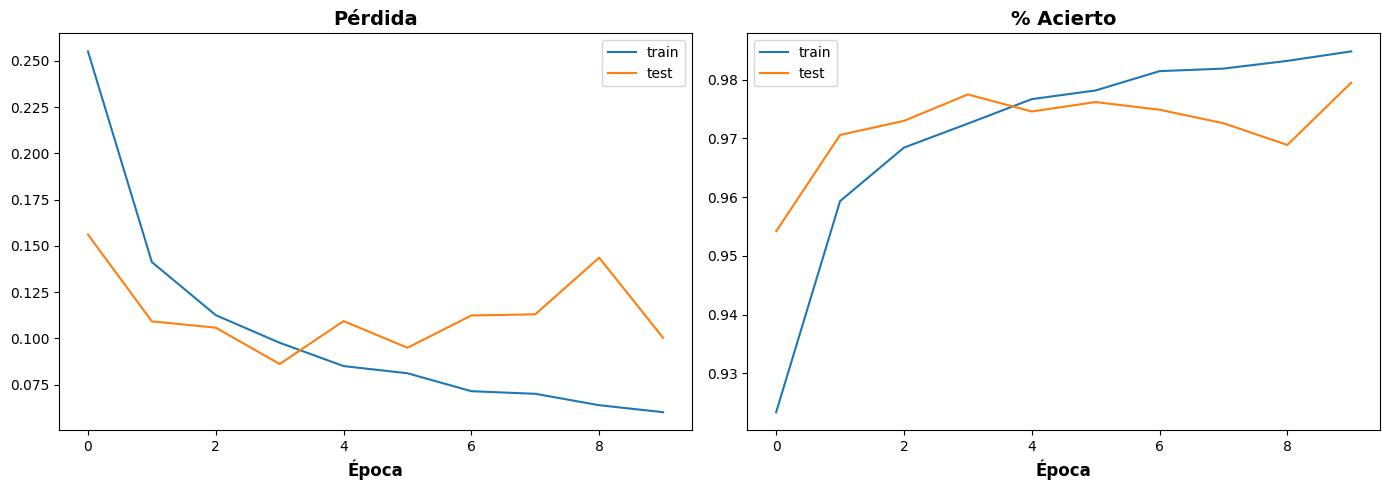

In [28]:
history = train_model(history, model, X_train, y_train, X_test, y_test, 10)

model.save(f"{model.name}.h5")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 fila, 2 columnas

# Gráfico de pérdida
axes[0].plot(history[model.name]["result"].history['loss'], label="train")
axes[0].plot(history[model.name]["result"].history['val_loss'], label="test")
axes[0].set_title('Pérdida', fontsize=14, fontweight="bold")
axes[0].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[0].legend()

# Gráfico de precisión
axes[1].plot(history[model.name]["result"].history['accuracy'], label="train")
axes[1].plot(history[model.name]["result"].history['val_accuracy'], label="test")
axes[1].set_title('% Acierto', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Época', fontsize=12, fontweight="bold")
axes[1].legend()

plt.tight_layout()
plt.show()


En este caso tambien se puede observar fluctuaciones en el rendimiento de ambas fases, donde a partir de la epoca 4 en rendimiento empieza a decaer por ende utilizaremos esta epoca para la evaluacion.

Accuracy: 98.49% (Training) / 97.95% (testing) -> 0.54% de diferencia

Perdida: 0.0566 / 0.1004 -> 0.0438 diferencia de perdidas

como se puede observar el rendimiento general del modelo se vio afectado negativamente, esto puede ser debido a que al aplicarse a capas tempranas se elimina informacion importante que estas pueden entregar a las capas sub-siguientes ademas el la tecnica de dropout es ideal para eviar el sobreajuste, lo cual no se observa en esta muestra de datos ya que no hay una diferencia notoria en la fase de training y testing.

#Evaluación

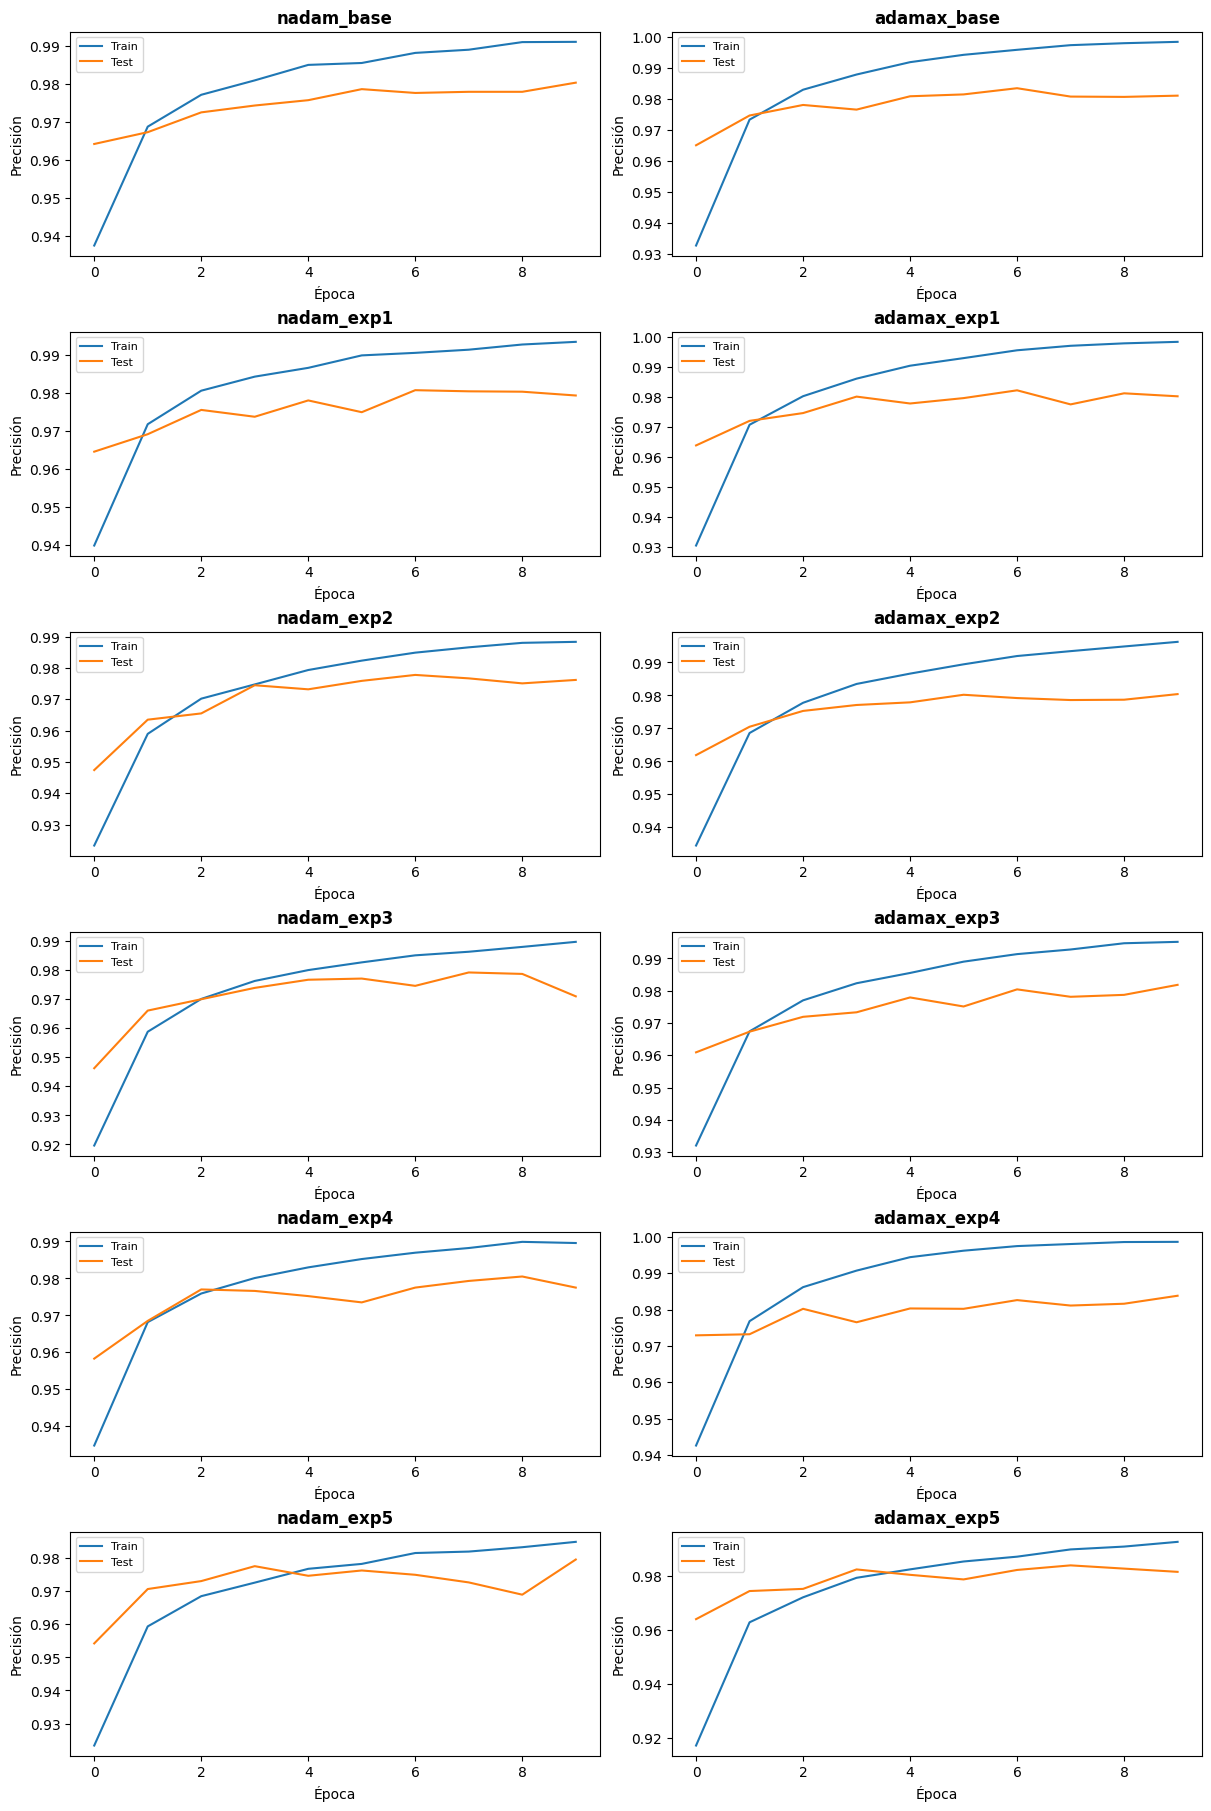

In [35]:
num_models = len(history)
rows = 6
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 3), constrained_layout=True)

model_items = list(history.items())

for i in range(min(6, num_models)):
    model_name, model_data = model_items[i]
    ax = axes[i][1]
    ax.plot(model_data["result"].history['accuracy'], label="Train")
    ax.plot(model_data["result"].history['val_accuracy'], label="Test")
    ax.set_title(f'{model_name}', fontsize=12, fontweight="bold")
    ax.set_xlabel('Época', fontsize=10)
    ax.set_ylabel('Precisión', fontsize=10)
    ax.legend(fontsize=8)

for i in range(6, min(12, num_models)):
    model_name, model_data = model_items[i]
    ax = axes[i - 6][0]
    ax.plot(model_data["result"].history['accuracy'], label="Train")
    ax.plot(model_data["result"].history['val_accuracy'], label="Test")
    ax.set_title(f'{model_name}', fontsize=12, fontweight="bold")
    ax.set_xlabel('Época', fontsize=10)
    ax.set_ylabel('Precisión', fontsize=10)
    ax.legend(fontsize=8)

for i in range(num_models, 12):
    col = 1 if i < 6 else 0
    row = i if i < 6 else i - 6
    axes[row][col].axis('off')

plt.show()

Luego de los gráficos comparativos de todos los experimentos, se puede concluir que los ajustes realizados en los modelos permitieron una mejora en la función de pérdida, manteniendo una precisión (accuracy) muy cercana a la de los modelos base. Esto sugiere que las modificaciones introducidas optimizaron el proceso de aprendizaje sin comprometer significativamente la capacidad de generalización. A continuación, se procederá a comparar los modelos base con aquellos correspondientes a la última experimentación, con el objetivo de analizar en mayor profundidad el impacto de dichos ajustes sobre el rendimiento del modelo.

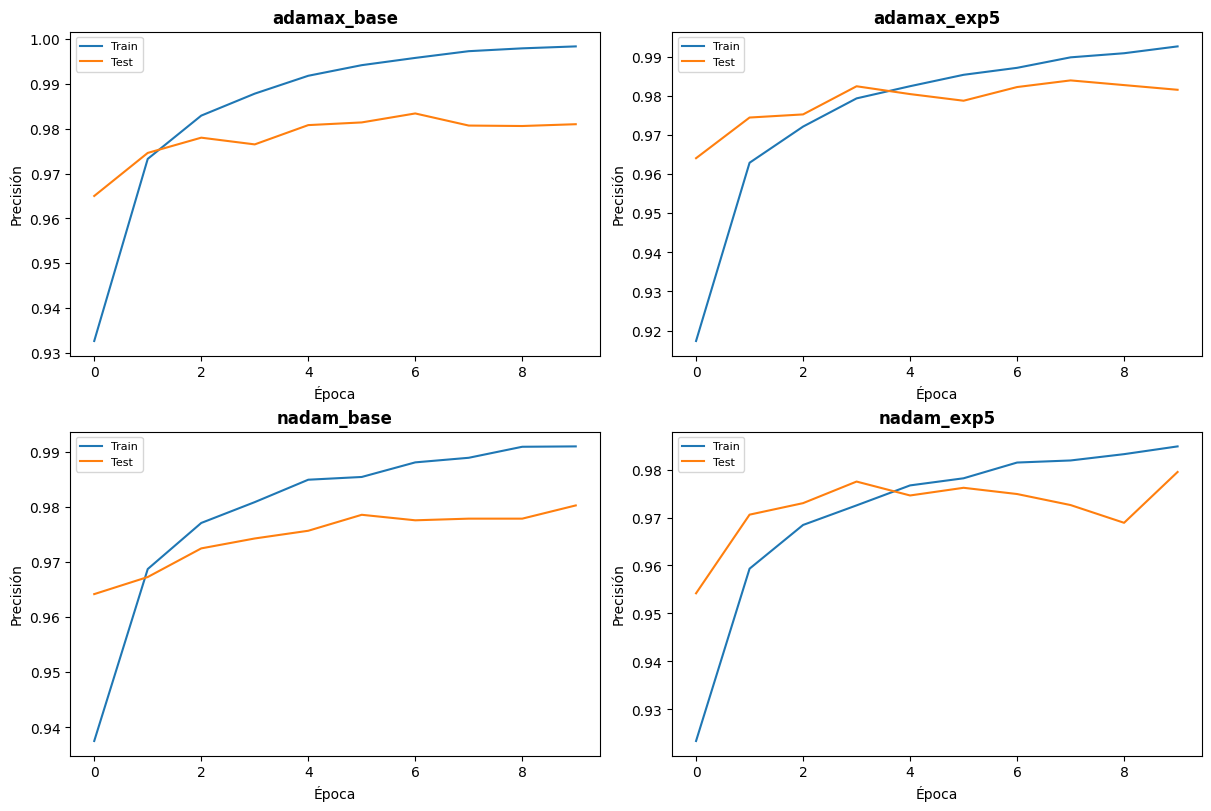

In [38]:
selected_indices = [0, 5, 6, 11]
selected_models = [list(history.items())[i] for i in selected_indices]

# Crear la figura 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

# Aplanar los ejes para iterar fácilmente
axes = axes.flatten()

# Graficar los 4 modelos seleccionados
for i, (model_name, model_data) in enumerate(selected_models):
    ax = axes[i]
    ax.plot(model_data["result"].history['accuracy'], label="Train")
    ax.plot(model_data["result"].history['val_accuracy'], label="Test")
    ax.set_title(f'{model_name}', fontsize=12, fontweight="bold")
    ax.set_xlabel('Época', fontsize=10)
    ax.set_ylabel('Precisión', fontsize=10)
    ax.legend(fontsize=8)

# Ocultar ejes restantes si hubiera alguno
for j in range(len(selected_models), 4):
    axes[j].axis('off')

plt.show()


En el gráfico se comparan modelos de clasificación entrenados con diferentes optimizadores, donde los de la izquierda (adamax_base y nadam_base) representan las versiones base y los de la derecha (adamax_exp5 y nadam_exp5) son sus versiones mejoradas o ajustadas. En general, todos los modelos alcanzan una precisión muy alta, superior al 97%, lo cual indica un buen desempeño. Los modelos base muestran una evolución estable tanto en entrenamiento como en validación, con diferencias pequeñas entre ambas curvas, lo que sugiere un entrenamiento equilibrado y sin signos evidentes de sobreajuste. Por otro lado, los modelos mejorados alcanzan precisiones de entrenamiento similares o superiores, pero presentan mayor variabilidad en la curva de validación. En particular, nadam_exp5 muestra una caída en la precisión de validación hacia las últimas épocas, lo que puede indicar un inicio de sobreajuste. En contraste, adamax_exp5 se comporta de forma más estable, aunque también con ligeras oscilaciones.

# Mejor modelo

El modelo seleccionado como el mejor calificado entre todos los evaluados es la Red Neuronal 1 del Experimento 5. Aunque todos los modelos presentan un accuracy similar, este modelo destaca por presentar la menor función de pérdida tanto en el conjunto de entrenamiento como en el de prueba, lo que indica una mejor capacidad de generalización y un menor sobreajuste (overfitting).